In [1]:
import ROOT as rt
import root_numpy as rtnp
import csv
import re
import sys
import uproot
import numpy as np
import awkward
import math
import numba

from matplotlib import pyplot as plt
sys.path.append('/nfshome/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list
from array import array
#from prettytable import PrettyTable
import collections
from collections import OrderedDict
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []


Welcome to JupyROOT 6.16/00


In [2]:
directory = '/mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/'
out_dir = '/nfshome/jmao/cms-llp/plots/20190716/'
name_string1 = 'ntuple_RunIISummer16_'
name_string2 = '.root'

labels = {'bbbb_ggh_mh125_mx50_pl10000',
          'bbbb_ggh_mh125_mx50_pl1000',
          'bbbb_ggh_mh2000_mx975_pl1000'}

texs = {}

texs['bbbb_ggh_mh125_mx50_pl10000'] = 'm_{h} = 125 GeV, m_{x} = 50 GeV, c#tau = 10m'
texs['bbbb_ggh_mh125_mx50_pl1000'] = 'm_{h} = 125 GeV, m_{x} = 50 GeV, c#tau = 1m'
texs['bbbb_ggh_mh2000_mx975_pl1000'] = 'm_{h} = 2000 GeV, m_{x} = 975 GeV, c#tau = 1m'

MODEL = 'pp #rightarrow XX, X #rightarrow bb, X #rightarrow bb, ggH'

fpath = OrderedDict()
tree = OrderedDict()
nevts = OrderedDict()
for label in labels:
    print(label)
    fpath[label] = directory + name_string1 + label + name_string2
    print (label, fpath[label])

    print ('File ready')


    root_dir = uproot.open(fpath[label]) 
    print ('Open ready')

    tree[label] = root_dir['ntuples/llp']
    print ('Tree ready')

    nevts[label] = root_dir['ntuples/NEvents'][1]
    print ('NEvents = ', nevts[label])
    print ('NEvents ready')


bbbb_ggh_mh125_mx50_pl10000
bbbb_ggh_mh125_mx50_pl10000 /mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/ntuple_RunIISummer16_bbbb_ggh_mh125_mx50_pl10000.root
File ready
Open ready
Tree ready
NEvents =  50973.0
NEvents ready
bbbb_ggh_mh125_mx50_pl1000
bbbb_ggh_mh125_mx50_pl1000 /mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/ntuple_RunIISummer16_bbbb_ggh_mh125_mx50_pl1000.root
File ready
Open ready
Tree ready
NEvents =  50918.0
NEvents ready
bbbb_ggh_mh2000_mx975_pl1000
bbbb_ggh_mh2000_mx975_pl1000 /mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/ntuple_RunIISummer16_bbbb_ggh_mh2000_mx975_pl1000.root
File ready
Open ready
Tree ready
NEvents =  17362.0
NEvents ready


In [3]:
#sort lists based on list1 and require list1 to be valid
def sort_valid_lists(list1, list2): 
    list3 = []
    for index, (ele1,ele2) in enumerate(zip(list1,list2)): 
#         print(index,ele1,ele2)
        if not math.isnan(ele1):
#             print("ele1 is not nan")
            list3.append(tuple((ele1,ele2)))
    list3.sort(key=lambda x: x[0])
    return list3 

# Smear jet time cut

In [5]:
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
print(len(t_cuts))
sigma = [0.193]
print(len(sigma))
print(len(tree))
ntr = len(tree)

i=0

Firsts = []
Seconds = []
# loop over events and get an array of maximum jet time in events
for k,v in tree.items():   

#         print(i, k, v)
    jetGenTime = v['gen_time_ETL'].array()
    BSTime = v['genVertexT'].array()

    jetTime = [x-y for x,y in zip(jetGenTime,BSTime)]
    
#     print(jetGenTime[0],BSTime[0], jetTime[0])\


    jetPt = v['gLLP_daughter_pt'].array()
    weight = v['genWeight'].array()
    
    for j,sig in enumerate(sigma):
#     for j,sig in enumerate(sigma):
#         print(j,sig)
        n = i*len(sigma)+j
#         print('n',n)
        print(i, j, n,len(weight))
        SmearTime = np.random.normal(0,sig,len(BSTime))
        jetNewTime = [x+y for x,y in zip(jetTime,SmearTime)]
#         print(jetTime[0],SmearTime[0], jetNewTime[0])    

    
        jetTime_most_delayed = []
        jetTime_second_delayed = []

        for evt, (time, pt) in enumerate(zip(jetNewTime,jetPt)):
    #         print(i,time,pt,len(time),len(pt))
            time_s =[]
            pt_s= []
            for par in range(len(time)):
    #             print(j,pt[j])
                time_s.append(time[par])
                pt_s.append(pt[par])
    #         print(i,time_s)
    #         print(i,pt_s)
            validpairlist = sort_valid_lists(time_s,pt_s)
    #         print(i,validpairlist)
    #         print(validpairlist[-1][0])
            if len(validpairlist)>1 :
    #             print(i,len(validpairlist))
    #             print(i,validpairlist[-1][0],validpairlist[-2][0])
                jetTime_most_delayed.append(validpairlist[-1][0])
                jetTime_second_delayed.append(validpairlist[-2][0])
            else:
                jetTime_most_delayed.append(-666)
                jetTime_second_delayed.append(-666)
#             if i>2:
#                 break
        jetTime_most_delayed = np.array(jetTime_most_delayed)
        jetTime_second_delayed = np.array(jetTime_second_delayed)
#         print(i, j, n,len(jetTime_most_delayed),len(jetTime_second_delayed))
    
        Firsts.append(jetTime_most_delayed)
        Seconds.append(jetTime_second_delayed)
#         print(n,'found max jet gen time')

    i += 1
    
Firsts = np.array(Firsts)
Seconds = np.array(Seconds)
print('found max, second jet gen time')
print(len(Firsts),len(Seconds))


19
1
3
0 0 0 50973
1 0 1 50918
2 0 2 17362
found max, second jet gen time
3 3


In [6]:
i = 0
Power_1j = []
Power_2j = []

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,sig in enumerate(sigma):
        print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+j
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts[n] 
        jetGenTime_second = Seconds[n] 
        print(len(weight),len(Firsts[n]),len(Seconds[n]))
        
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)
    #         print(tcut_string)
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
    #         print(tcut666_string1)
    #         print(tcut666_string)
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
            Ntotal_1j_w = np.sum(weight1_cut666)
            Ntotal_2j_w = np.sum(weight_cut666)
    #         print('1j total',Ntotal_1j_w)
    #         print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]
    #         Nsel_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.sum(tcutted_w1_v)
            Nsel_2j_w = np.sum(tcutted_w_v)
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j.append(Power_eff_1j)
        Power_2j.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j = np.array(Power_1j)
Power_2j = np.array(Power_2j)
print(Power_1j)
print(Power_2j)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0.193
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
0 0.193
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
0 0.193
17362 17362 17362
[[1.         1.         1.         1.         1.         1.
  0.99882468 0.99294814 0.96826644 0.90244858 0.79666982 0.67463275
  0.55377083 0.46679724 0.39647398 0.17786484 0.10127325 0.06679726
  0.0503428 ]
 [1.         1.         1.         1.         1.         0.99983665
  0.99873409 0.99019931 0.95508012 0.86818038 0.72084289 0.55855934
  0.42163507 0.31586897 0.23979096 0.07326038 0.03001471 0.01490526
  0.00788141]
 [1.         1.         1.         1.         1.         1.
  0.99985716 0.99771433 0.98871431 0.96842858 0.92571424 0.87128563
  0.80942853 0.7544285  0.69185708 0.44614283 0.2762857  0.17371428
  0.11285714]]
[[1.         1.         1.         1.         1.         0.99931926
  0.99863852 0.99115041 0.940095

bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0.193
0 0 0
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
0 0.193
1 0 1
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
0 0.193
2 0 2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_2line.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_2line.pdf has been created


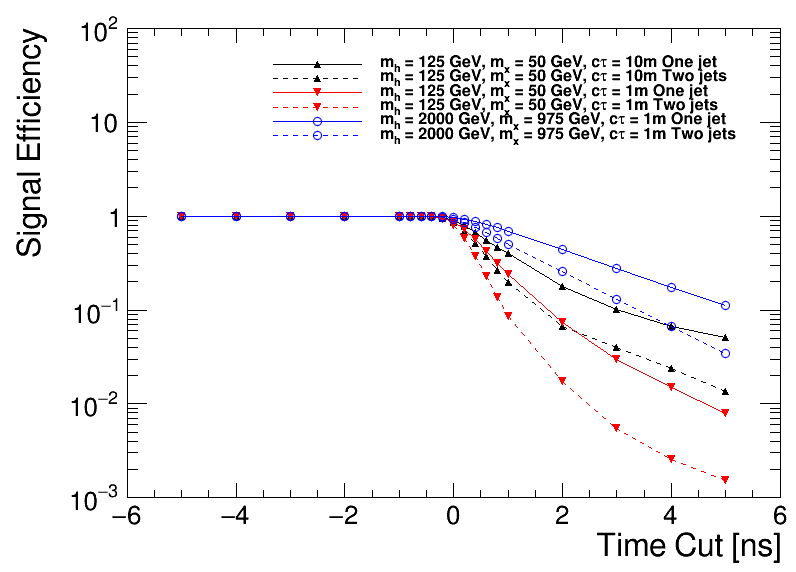

In [10]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.32,0.75,0.95,0.90);
leg.SetTextSize(0.03)
rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,sig in enumerate(sigma):
        print(j,sig)

        i = n*len(sigma)+j
        print(n,j,i)

        Power_eff_i = Power_1j[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)


        leg.SetBorderSize(0)
 

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-3,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and i==0 :
            h1s[i].Draw('ALPsame')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h1s[i],texs[k]+' One jet')
            leg.AddEntry(h2s[i],texs[k]+' Two jets')
        elif j==0:
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h1s[i],texs[k]+' One jet')
            leg.AddEntry(h2s[i],texs[k]+' Two jets')
    
    n += 1


leg.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_2line.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_2line.pdf')


# Decay before ECAL volume

In [11]:
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
print(len(t_cuts))
sigma=[0.193]
print(len(sigma))
print(len(tree))
ntr = len(tree)

i=0

Firsts_ecal = []
Seconds_ecal = []
# loop over events and get an array of maximum jet time in events
for k,v in tree.items():   

#         print(i, k, v)
    jetGenTime = v['gen_time_ETL'].array()
    BSTime = v['genVertexT'].array()

    jetTime = [x-y for x,y in zip(jetGenTime,BSTime)]
    
#     print(jetGenTime[0],BSTime[0], jetTime[0])

    jetPt = v['gLLP_daughter_pt'].array()
    weight = v['genWeight'].array()
    
    for j,sig in enumerate(sigma):
#     for j,sig in enumerate(sigma):
#         print(j,sig)
        n = i*len(sigma)+j
#         print('n',n)
        print(i, j, n,len(weight))
        SmearTime = np.random.normal(0,sig,len(BSTime))
        jetNewTime = [x+y for x,y in zip(jetTime,SmearTime)]
#         print(jetTime[0],SmearTime[0], jetNewTime[0])    

    
        jetTime_most_delayed = []
        jetTime_second_delayed = []

        for evt, (time, pt) in enumerate(zip(jetNewTime,jetPt)):
    #         print(i,time,pt,len(time),len(pt))
            time_s =[]
            pt_s= []
            for par in range(len(time)):
    #             print(j,pt[j])
                time_s.append(time[par])
                pt_s.append(pt[par])
    #         print(i,time_s)
    #         print(i,pt_s)
            validpairlist = sort_valid_lists(time_s,pt_s)
    #         print(i,validpairlist)
    #         print(validpairlist[-1][0])
            if len(validpairlist)>1 :
    #             print(i,len(validpairlist))
    #             print(i,validpairlist[-1][0],validpairlist[-2][0])
                jetTime_most_delayed.append(validpairlist[-1][0])
                jetTime_second_delayed.append(validpairlist[-2][0])
            else:
                jetTime_most_delayed.append(-666)
                jetTime_second_delayed.append(-666)
#             if i>2:
#                 break
        jetTime_most_delayed = np.array(jetTime_most_delayed)
        jetTime_second_delayed = np.array(jetTime_second_delayed)
#         print(i, j, n,len(jetTime_most_delayed),len(jetTime_second_delayed))
    
        Firsts_ecal.append(jetTime_most_delayed)
        Seconds_ecal.append(jetTime_second_delayed)
#         print(n,'found max jet gen time')

    i += 1
    
Firsts_ecal = np.array(Firsts_ecal)
Seconds_ecal = np.array(Seconds_ecal)
print('found max, second jet gen time')
print(len(Firsts_ecal),len(Seconds_ecal))


19
1
3
0 0 0 50973
1 0 1 50918
2 0 2 17362
found max, second jet gen time
3 3


In [12]:
i = 0
Power_1j_ecal = []
Power_2j_ecal = []

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,sig in enumerate(sigma):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+j
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_ecal[n] 
        jetGenTime_second = Seconds_ecal[n] 
        print(len(weight),len(Firsts_ecal[n]),len(Seconds_ecal[n]))
        
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)
    #         print(tcut_string)
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
    #         print(tcut666_string1)
    #         print(tcut666_string)
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
#             Ntotal_1j_w = np.sum(weight1_cut666)          
#             Ntotal_2j_w = np.sum(weight_cut666)
#             Ntotal_1j_w = np.shape(weight1_cut666)[0]          
#             Ntotal_2j_w = np.shape(weight_cut666)[0]
            Ntotal_1j_w = nevts[k]          
            Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]
    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.shape(tcutted_w1_v)[0]
            Nsel_2j_w = np.shape(tcutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_ecal.append(Power_eff_1j)
        Power_2j_ecal.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_ecal = np.array(Power_1j_ecal)
Power_2j_ecal = np.array(Power_2j_ecal)
print(Power_1j_ecal)
print(Power_2j_ecal)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
17362 17362 17362
[[0.10015106 0.10015106 0.10015106 0.10015106 0.10015106 0.10015106
  0.10007259 0.0994448  0.097071   0.09024385 0.07992467 0.06713358
  0.05610814 0.04712299 0.03964844 0.01759755 0.0102211  0.00678791
  0.00510074]
 [0.48093012 0.48093012 0.48093012 0.48093012 0.48091048 0.4808712
  0.48034094 0.47629522 0.45903217 0.41708237 0.3476963  0.26884402
  0.20175576 0.15277505 0.11587258 0.03525276 0.01469029 0.00708983
  0.00369221]
 [0.40317936 0.40317936 0.40317936 0.40317936 0.40317936 0.40317936
  0.40306416 0.4023154  0.39908997 0.39010483 0.37455362 0.3515148
  0.32743924 0.30198134 0.27882732 0.18073955 0.11145029 0.07049879
  0.04544407]]
[[0.02881918 0.02881918 0.02881918 0.02881918 0.02881918 0.02881918
  0.02881918 0.02856414 0.02742628 0.02473

bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0 0
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 1
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 0 2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_Ecal_2line.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_Ecal_2line.pdf has been created


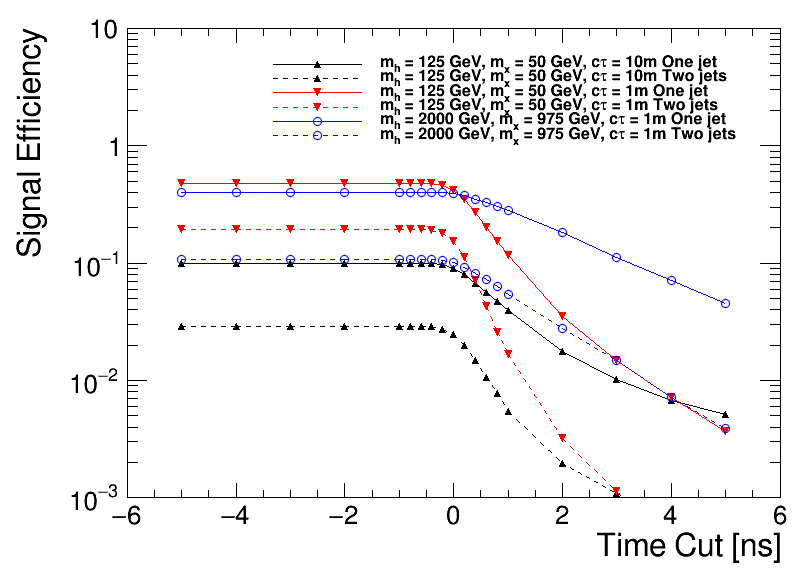

In [15]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.32,0.75,0.95,0.90);
leg.SetTextSize(0.03)
rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,sig in enumerate(sigma):
#         print(j,sig)

        i = n*len(sigma)+j
        print(n,j,i)

        Power_eff_i = Power_1j_ecal[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_ecal[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)


        leg.SetBorderSize(0)


        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-3,1e1)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if i==0 and j==0:
            h1s[i].Draw('ALPsame')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h1s[i],texs[k]+' One jet')
            leg.AddEntry(h2s[i],texs[k]+' Two jets')
        elif j==0:
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h1s[i],texs[k]+' One jet')
            leg.AddEntry(h2s[i],texs[k]+' Two jets')
    
    n += 1


leg.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_Ecal_2line.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_Ecal_2line.pdf')


# Real trigger case (Pt & Time)

In [16]:
i = 0

Pt_maxes = []
Pt_seconds = []
for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()
    jetPt = v['gLLP_daughter_pt'].array()
    
    jetPt = np.array(jetPt)
    
    maxes = jetPt[:,0]
    seconds = jetPt[:,1]
#     print(jetPt[0],maxes[0],seconds[0])
#     print(jetPt[1],maxes[1],seconds[1])
    
    maxes = np.array(maxes)
    seconds = np.array(seconds)
    print(i, len(weight), len(maxes),len(seconds))    

    Pt_maxes.append(maxes)
    Pt_seconds.append(seconds)
    
    i += 1

Pt_maxes = np.array(Pt_maxes)
Pt_seconds = np.array(Pt_seconds)
print('found max second Pts', len(Pt_maxes),len(Pt_seconds))

bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 17362 17362 17362
found max second Pts 3 3


In [17]:
i = 0
Power_1j_trg = []
Power_2j_trg = []

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,sig in enumerate(sigma):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+j
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_ecal[n] 
        jetGenTime_second = Seconds_ecal[n] 
        print(len(weight),len(Firsts_ecal[n]),len(Seconds_ecal[n]))
        
        jetPt_max = Pt_maxes[i] 
        jetPt_second = Pt_seconds[i] 
        print(len(weight),len(Pt_maxes[i]),len(Pt_seconds[i]))
        
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)
            
            ptcut_string1 = np.logical_and( jetPt_max > 60, jetPt_max>-600)
            ptcut_string2 = np.logical_and( jetPt_second > 60, jetPt_second>-600)
            ptcut_string = np.logical_and( ptcut_string1, ptcut_string2)
           
            cut_string = np.logical_and( ptcut_string1, tcut_string)
            cut_string1 = np.logical_and( ptcut_string1, tcut_string1)
            cut_string2 = np.logical_and( ptcut_string2, tcut_string2)
            

            Ntotal_1j_w = nevts[k]          
            Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]
            
            ptcutted_w_v = weight[ptcut_string]
            ptcutted_w1_v = weight[ptcut_string1]
            ptcutted_w2_v = weight[ptcut_string2]
            
            
            cutted_w_v = weight[cut_string]
            cutted_w1_v = weight[cut_string1]
            cutted_w2_v = weight[cut_string2]
            
            
    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.shape(cutted_w1_v)[0]
            Nsel_2j_w = np.shape(cutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_trg.append(Power_eff_1j)
        Power_2j_trg.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_trg = np.array(Power_1j_trg)
Power_2j_trg = np.array(Power_2j_trg)
print(Power_1j_trg)
print(Power_2j_trg)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
50918 50918 50918
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
17362 17362 17362
17362 17362 17362
[[2.29533282e-03 2.29533282e-03 2.29533282e-03 2.29533282e-03
  2.29533282e-03 2.29533282e-03 2.27571459e-03 2.27571459e-03
  2.19724168e-03 2.04029584e-03 1.74602240e-03 1.35365782e-03
  1.25556667e-03 1.07900261e-03 9.02438546e-04 5.29692190e-04
  3.33509897e-04 2.74655210e-04 1.76564063e-04]
 [1.35904788e-02 1.35904788e-02 1.35904788e-02 1.35904788e-02
  1.35904788e-02 1.35708394e-02 1.35315605e-02 1.32173298e-02
  1.23924742e-02 1.10766330e-02 9.11269099e-03 6.87379709e-03
  4.98841274e-03 3.77076869e-03 2.88699478e-03 1.02124985e-03
  6.08822028e-04 2.35673043e-04 1.37475942e-04]
 [3.96728488e-01 3.96728488e-01 3.96728488e-01 3.96728488e-01
  3.96728488e-01 3.96728488e-01 3.96613293e-01 3.958645

bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0 0
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 1
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 0 2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_trg_2line.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_trg_2line.pdf has been created


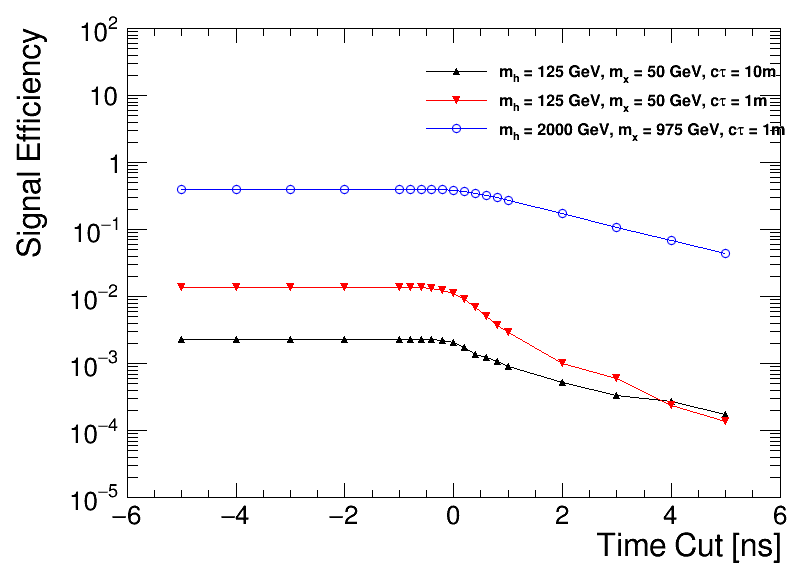

In [18]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,sig in enumerate(sigma):
#         print(j,sig)

        i = n*len(sigma)+j
        print(n,j,i)

        Power_eff_i = Power_1j_trg[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_trg[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==0 :
            h1s[i].Draw('ALPsame')
        elif j==0:
            h1s[i].Draw('LPsame')
            
        if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
            leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==0:
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_trg_2line.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_trg_2line.pdf')


# Pt thresholds scan

In [19]:
i = 0
Power_1j_trgs = []
Power_2j_trgs = []

pt_cuts = [0, 20,30,40,50,60]

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+0
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_ecal[n] 
        jetGenTime_second = Seconds_ecal[n] 
        print(len(weight),len(Firsts_ecal[n]),len(Seconds_ecal[n]))
        
        jetPt_max = Pt_maxes[i] 
        jetPt_second = Pt_seconds[i] 
        print(len(weight),len(Pt_maxes[i]),len(Pt_seconds[i]))

#         for mm, nn in enumerate(pt_cuts):
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)

            ptcut_string1 = np.logical_and( jetPt_max > pt, jetPt_max>-600)
            ptcut_string2 = np.logical_and( jetPt_second > pt, jetPt_second>-600)
            ptcut_string = np.logical_and( ptcut_string1, ptcut_string2)

            cut_string = np.logical_and( ptcut_string1, tcut_string)
            cut_string1 = np.logical_and( ptcut_string1, tcut_string1)
            cut_string2 = np.logical_and( ptcut_string2, tcut_string2)


            Ntotal_1j_w = nevts[k]          
            Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]

            ptcutted_w_v = weight[ptcut_string]
            ptcutted_w1_v = weight[ptcut_string1]
            ptcutted_w2_v = weight[ptcut_string2]


            cutted_w_v = weight[cut_string]
            cutted_w1_v = weight[cut_string1]
            cutted_w2_v = weight[cut_string2]


    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.shape(cutted_w1_v)[0]
            Nsel_2j_w = np.shape(cutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_trgs.append(Power_eff_1j)
        Power_2j_trgs.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_trgs = np.array(Power_1j_trgs)
Power_2j_trgs = np.array(Power_2j_trgs)
print(len(Power_1j_trgs))
print(len(Power_2j_trgs))


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
18
18


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 6
1 1 7
1 2 8
1 3 9
1 4 10
1 5 11
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_trgs_2line.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_trgs_2line.pdf has been created


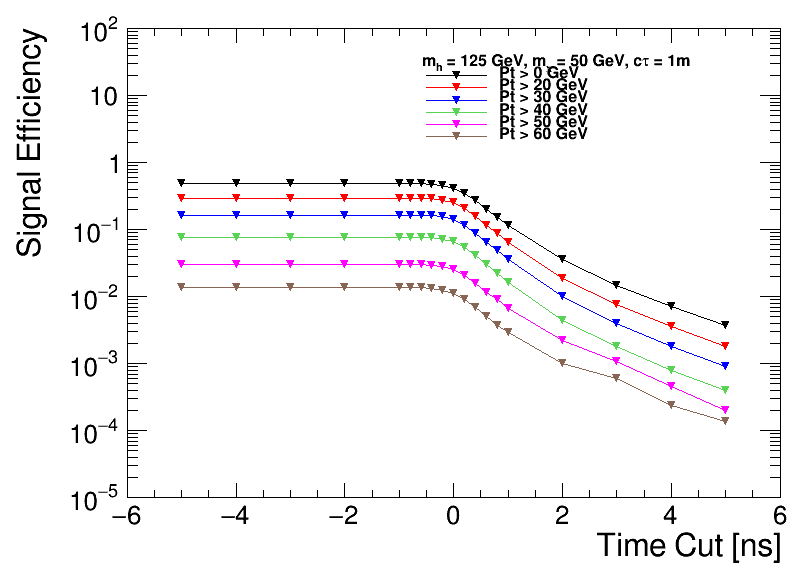

In [20]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==1:
            print(n,j,i)
            h1s[i].Draw('ALPsame')
        elif n==1:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if n==1:
            leg1.SetHeader(texs[k])
            leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_trgs_2line.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_trgs_2line.pdf')


# others

In [15]:
test = 180*math.atan(1)/math.pi
print(test,' deg')
test1 = math.tan(math.atan(1))
print(test1, 'tan value')
theta = 2*math.atan(math.exp(-1.479))
z = 1.29/math.tan(theta)
print(theta,z)

45.0  deg
0.9999999999999999 tan value
0.4480802598611997 2.683644721727066


In [16]:
theta = 2*math.atan(math.exp(-1.78377))
z = 1.29/math.tan(theta)
print(theta,z)

0.33289834738058155 3.7308416319407427


In [17]:
import numpy as np

print('Does Olmo suck?')
if np.random.uniform() > 0.5:
    print ('Yes')
else: print ('No')

Does Olmo suck?
No


In [18]:
theta = 2*math.atan(math.exp(-1.7837746))
z = -0.538/math.tan(theta)
print(theta,z)


0.33289684417918397 -1.5559709825134156


# TOTAL NUM = TOTAL EVENTS

In [21]:
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
print(len(t_cuts))
sigma = [0.193]
print(len(sigma))
print(len(tree))
ntr = len(tree)

i=0

Firsts_Ecal = []
Seconds_Ecal = []
# loop over events and get an array of maximum jet time in events
for k,v in tree.items():   

#         print(i, k, v)
    jetGenTime = v['gen_time_ETL'].array()
    BSTime = v['genVertexT'].array()

    jetTime = [x-y for x,y in zip(jetGenTime,BSTime)]
    
#     print(jetGenTime[0],BSTime[0], jetTime[0])

    jetPt = v['gLLP_daughter_pt'].array()
    weight = v['genWeight'].array()
    
    for j,sig in enumerate(sigma):
#     for j,sig in enumerate(sigma):
#         print(j,sig)
        n = i*len(sigma)+j
#         print('n',n)
        print(i, j, n,len(weight))
        SmearTime = np.random.normal(0,sig,len(BSTime))
        jetNewTime = [x+y for x,y in zip(jetTime,SmearTime)]
#         print(jetTime[0],SmearTime[0], jetNewTime[0])    

    
        jetTime_most_delayed = []
        jetTime_second_delayed = []

        for evt, (time, pt) in enumerate(zip(jetNewTime,jetPt)):
    #         print(i,time,pt,len(time),len(pt))
            time_s =[]
            pt_s= []
            for par in range(len(time)):
    #             print(j,pt[j])
                time_s.append(time[par])
                pt_s.append(pt[par])
    #         print(i,time_s)
    #         print(i,pt_s)
            validpairlist = sort_valid_lists(time_s,pt_s)
    #         print(i,validpairlist)
    #         print(validpairlist[-1][0])
            if len(validpairlist)>1 :
    #             print(i,len(validpairlist))
    #             print(i,validpairlist[-1][0],validpairlist[-2][0])
                jetTime_most_delayed.append(validpairlist[-1][0])
                jetTime_second_delayed.append(validpairlist[-2][0])
            else:
                jetTime_most_delayed.append(-666)
                jetTime_second_delayed.append(-666)
#             if i>2:
#                 break
        jetTime_most_delayed = np.array(jetTime_most_delayed)
        jetTime_second_delayed = np.array(jetTime_second_delayed)
#         print(i, j, n,len(jetTime_most_delayed),len(jetTime_second_delayed))
    
        Firsts_Ecal.append(jetTime_most_delayed)
        Seconds_Ecal.append(jetTime_second_delayed)
#         print(n,'found max jet gen time')

    i += 1
    
Firsts_Ecal = np.array(Firsts_Ecal)
Seconds_Ecal = np.array(Seconds_Ecal)
print('found max, second jet gen time')
print(len(Firsts_Ecal),len(Seconds_Ecal))


19
1
3
0 0 0 50973
1 0 1 50918
2 0 2 17362
found max, second jet gen time
3 3


In [22]:
i = 0
Power_1j_Ecal = []
Power_2j_Ecal = []

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,sig in enumerate(sigma):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+j
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_Ecal[n] 
        jetGenTime_second = Seconds_Ecal[n] 
        print(len(weight),len(Firsts_Ecal[n]),len(Seconds_Ecal[n]))
        
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)
    #         print(tcut_string)
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
    #         print(tcut666_string1)
    #         print(tcut666_string)
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
#             Ntotal_1j_w = np.sum(weight1_cut666)          
#             Ntotal_2j_w = np.sum(weight_cut666)
            Ntotal_1j_w = nevts[k]         
            Ntotal_2j_w = nevts[k]
#             Ntotal_1j_w = np.shape(weight1_cut666)[0]          
#             Ntotal_2j_w = np.shape(weight_cut666)[0]
#             Ntotal_1j_w = nevts[k]          
#             Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]
    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.shape(tcutted_w1_v)[0]
            Nsel_2j_w = np.shape(tcutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_Ecal.append(Power_eff_1j)
        Power_2j_Ecal.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_Ecal = np.array(Power_1j_Ecal)
Power_2j_Ecal = np.array(Power_2j_Ecal)
# print(Power_1j_Ecal)
# print(Power_2j_Ecal)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
17362 17362 17362


In [23]:
i = 0
Power_1j_Trgs = []
Power_2j_Trgs = []

pt_cuts = [0,20,30,40,50,60]

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+0
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_ecal[n] 
        jetGenTime_second = Seconds_ecal[n] 
        print(len(weight),len(Firsts_ecal[n]),len(Seconds_ecal[n]))
        
        jetPt_max = Pt_maxes[i] 
        jetPt_second = Pt_seconds[i] 
        print(len(weight),len(Pt_maxes[i]),len(Pt_seconds[i]))

#         for mm, nn in enumerate(pt_cuts):
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)

            ptcut_string1 = np.logical_and( jetPt_max > pt, jetPt_max>-600)
            ptcut_string2 = np.logical_and( jetPt_second > pt, jetPt_second>-600)
            ptcut_string = np.logical_and( ptcut_string1, ptcut_string2)

            cut_string = np.logical_and( ptcut_string1, tcut_string)
            cut_string1 = np.logical_and( ptcut_string1, tcut_string1)
            cut_string2 = np.logical_and( ptcut_string2, tcut_string2)
            
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
    #         print(tcut666_string1)
    #         print(tcut666_string)
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
#             Ntotal_1j_w = np.sum(weight1_cut666)          
#             Ntotal_2j_w = np.sum(weight_cut666)
#             Ntotal_1j_w = np.shape(weight1_cut666)[0]          
#             Ntotal_2j_w = np.shape(weight_cut666)[0]

            Ntotal_1j_w = nevts[k]        
            Ntotal_2j_w = nevts[k]

#             Ntotal_1j_w = nevts[k]          
#             Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]

            ptcutted_w_v = weight[ptcut_string]
            ptcutted_w1_v = weight[ptcut_string1]
            ptcutted_w2_v = weight[ptcut_string2]


            cutted_w_v = weight[cut_string]
            cutted_w1_v = weight[cut_string1]
            cutted_w2_v = weight[cut_string2]


    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)

            Nsel_1j_w = np.shape(cutted_w1_v)[0]
            Nsel_2j_w = np.shape(cutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j)
        print('pt',pt)
        print('t cut',t_cuts)
        print('Signal Efficiency 1jet: ',Power_eff_1j)
        print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_Trgs.append(Power_eff_1j)
        Power_2j_Trgs.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_Trgs = np.array(Power_1j_Trgs)
Power_2j_Trgs = np.array(Power_2j_Trgs)
# print(Power_1j_Trgs[2])
# print(Power_2j_Trgs)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
50973 50973 50973
pt 0
t cut [-5.0, -4.0, -3.0, -2.0, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0]
Signal Efficiency 1jet:  [0.10015106 0.10015106 0.10015106 0.10015106 0.10015106 0.10015106
 0.10007259 0.0994448  0.097071   0.09024385 0.07992467 0.06713358
 0.05610814 0.04712299 0.03964844 0.01759755 0.0102211  0.00678791
 0.00510074]
Signal Efficiency 2jet:  [0.02881918 0.02881918 0.02881918 0.02881918 0.02881918 0.02881918
 0.02881918 0.02856414 0.02742628 0.02473859 0.01995174 0.01471367
 0.01051537 0.00772958 0.00547349 0.00196182 0.001079   0.00070626
 0.00041198]
50973 50973 50973
50973 50973 50973
pt 20
t cut [-5.0, -4.0, -3.0, -2.0, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0]
Signal Efficiency 1jet:  [0.05865851 0.05865851 0.05865851 0.05865851 0.05865851 0.05865851
 0.05858003 0.05820729 0.05663783 0.05238067 0.04608322 0.038000

pt 60
t cut [-5.0, -4.0, -3.0, -2.0, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0]
Signal Efficiency 1jet:  [0.39672849 0.39672849 0.39672849 0.39672849 0.39672849 0.39672849
 0.39661329 0.39586453 0.39269669 0.38382675 0.36850593 0.3457551
 0.32167953 0.29639442 0.2733556  0.17641977 0.10845525 0.06807971
 0.04337058]
Signal Efficiency 2jet:  [0.10511462 0.10511462 0.10511462 0.10511462 0.10511462 0.10511462
 0.10499942 0.10453865 0.10281074 0.09745421 0.08904504 0.07971432
 0.06951964 0.06064969 0.05206773 0.02689782 0.01422647 0.00685405
 0.00380141]


# TOTAL NUM = INSIDE ECAL

In [24]:
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
print(len(t_cuts))
sigma = [0.193]
print(len(sigma))
print(len(tree))
ntr = len(tree)

i=0

Firsts_Ecal = []
Seconds_Ecal = []
# loop over events and get an array of maximum jet time in events
for k,v in tree.items():   

#         print(i, k, v)
    jetGenTime = v['gen_time_ETL'].array()
    BSTime = v['genVertexT'].array()

    jetTime = [x-y for x,y in zip(jetGenTime,BSTime)]
    
#     print(jetGenTime[0],BSTime[0], jetTime[0])

    jetPt = v['gLLP_daughter_pt'].array()
    weight = v['genWeight'].array()
    
    for j,sig in enumerate(sigma):
#     for j,sig in enumerate(sigma):
#         print(j,sig)
        n = i*len(sigma)+j
#         print('n',n)
        print(i, j, n,len(weight))
        SmearTime = np.random.normal(0,sig,len(BSTime))
        jetNewTime = [x+y for x,y in zip(jetTime,SmearTime)]
#         print(jetTime[0],SmearTime[0], jetNewTime[0])    

    
        jetTime_most_delayed = []
        jetTime_second_delayed = []

        for evt, (time, pt) in enumerate(zip(jetNewTime,jetPt)):
    #         print(i,time,pt,len(time),len(pt))
            time_s =[]
            pt_s= []
            for par in range(len(time)):
    #             print(j,pt[j])
                time_s.append(time[par])
                pt_s.append(pt[par])
    #         print(i,time_s)
    #         print(i,pt_s)
            validpairlist = sort_valid_lists(time_s,pt_s)
    #         print(i,validpairlist)
    #         print(validpairlist[-1][0])
            if len(validpairlist)>1 :
    #             print(i,len(validpairlist))
    #             print(i,validpairlist[-1][0],validpairlist[-2][0])
                jetTime_most_delayed.append(validpairlist[-1][0])
                jetTime_second_delayed.append(validpairlist[-2][0])
            else:
                jetTime_most_delayed.append(-666)
                jetTime_second_delayed.append(-666)
#             if i>2:
#                 break
        jetTime_most_delayed = np.array(jetTime_most_delayed)
        jetTime_second_delayed = np.array(jetTime_second_delayed)
#         print(i, j, n,len(jetTime_most_delayed),len(jetTime_second_delayed))
    
        Firsts_Ecal.append(jetTime_most_delayed)
        Seconds_Ecal.append(jetTime_second_delayed)
#         print(n,'found max jet gen time')

    i += 1
    
Firsts_Ecal = np.array(Firsts_Ecal)
Seconds_Ecal = np.array(Seconds_Ecal)
print('found max, second jet gen time')
print(len(Firsts_Ecal),len(Seconds_Ecal))


19
1
3
0 0 0 50973
1 0 1 50918
2 0 2 17362
found max, second jet gen time
3 3


In [25]:
i = 0
Power_1j_Ecal = []
Power_2j_Ecal = []

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,sig in enumerate(sigma):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+j
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_Ecal[n] 
        jetGenTime_second = Seconds_Ecal[n] 
        print(len(weight),len(Firsts_Ecal[n]),len(Seconds_Ecal[n]))
        
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)
    #         print(tcut_string)
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
    #         print(tcut666_string1)
    #         print(tcut666_string)
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
#             Ntotal_1j_w = np.sum(weight1_cut666)          
#             Ntotal_2j_w = np.sum(weight_cut666)
            Ntotal_1j_w = np.shape(weight1_cut666)[0]          
            Ntotal_2j_w = np.shape(weight_cut666)[0]
#             Ntotal_1j_w = nevts[k]          
#             Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]
    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.shape(tcutted_w1_v)[0]
            Nsel_2j_w = np.shape(tcutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_Ecal.append(Power_eff_1j)
        Power_2j_Ecal.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_Ecal = np.array(Power_1j_Ecal)
Power_2j_Ecal = np.array(Power_2j_Ecal)
# print(Power_1j_Ecal)
# print(Power_2j_Ecal)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
17362 17362 17362


In [26]:
i = 0
Power_1j_Trgs = []
Power_2j_Trgs = []

pt_cuts = [0,20,30,40,50,60]

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()



    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        Power_eff_1j = []
        Power_eff_2j = []

        n = i*len(sigma)+0
#         print(n)
#         print(i,j,n,len(weight))

        jetGenTime_max = Firsts_ecal[n] 
        jetGenTime_second = Seconds_ecal[n] 
        print(len(weight),len(Firsts_ecal[n]),len(Seconds_ecal[n]))
        
        jetPt_max = Pt_maxes[i] 
        jetPt_second = Pt_seconds[i] 
        print(len(weight),len(Pt_maxes[i]),len(Pt_seconds[i]))

#         for mm, nn in enumerate(pt_cuts):
        for p, q in enumerate(t_cuts):
#             print(p,q)
#             n = i*ntr+j
#             jetGenTime_max = Firsts[n] 
#             jetGenTime_second = Seconds[n] 
#             if i==1 :
#                 print(len(weight),len(Firsts[n]),len(Seconds[n]))

            tcut_string1 = np.logical_and( jetGenTime_max > q, jetGenTime_max>-600)
            tcut_string2 = np.logical_and( jetGenTime_second > q, jetGenTime_second>-600)
            tcut_string = np.logical_and( tcut_string1, tcut_string2)

            ptcut_string1 = np.logical_and( jetPt_max > pt, jetPt_max>-600)
            ptcut_string2 = np.logical_and( jetPt_second > pt, jetPt_second>-600)
            ptcut_string = np.logical_and( ptcut_string1, ptcut_string2)

            cut_string = np.logical_and( ptcut_string1, tcut_string)
            cut_string1 = np.logical_and( ptcut_string1, tcut_string1)
            cut_string2 = np.logical_and( ptcut_string2, tcut_string2)
            
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
    #         print(tcut666_string1)
    #         print(tcut666_string)
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
#             Ntotal_1j_w = np.sum(weight1_cut666)          
#             Ntotal_2j_w = np.sum(weight_cut666)
            Ntotal_1j_w = np.shape(weight1_cut666)[0]          
            Ntotal_2j_w = np.shape(weight_cut666)[0]

#             Ntotal_1j_w = nevts[k]          
#             Ntotal_2j_w = nevts[k]
#             print('1j total',Ntotal_1j_w)
#             print('2j total',Ntotal_2j_w)

            tcutted_w_v = weight[tcut_string]
            tcutted_w1_v = weight[tcut_string1]
            tcutted_w2_v = weight[tcut_string2]

            ptcutted_w_v = weight[ptcut_string]
            ptcutted_w1_v = weight[ptcut_string1]
            ptcutted_w2_v = weight[ptcut_string2]


            cutted_w_v = weight[cut_string]
            cutted_w1_v = weight[cut_string1]
            cutted_w2_v = weight[cut_string2]


    #         Nsel_w = np.sum(tcutted_w_v)
#             Nsel_1j_w = np.sum(tcutted_w1_v)
#             Nsel_2j_w = np.sum(tcutted_w_v)
            Nsel_1j_w = np.shape(cutted_w1_v)[0]
            Nsel_2j_w = np.shape(cutted_w_v)[0]
    #         print(Nsel_w)
    #         Nrej_w = 1.*Ntotal_w - 1.*Nsel_w
    #         Prej_2j_i = 1.0*Ntotal_w/Nsel_w
    #         Power_rej_2j_i.append(Prej_2j_i)
            Peff_1j_i = 1.0*Nsel_1j_w/Ntotal_1j_w
            Peff_2j_i = 1.0*Nsel_2j_w/Ntotal_2j_w
            Power_eff_1j.append(Peff_1j_i)
            Power_eff_2j.append(Peff_2j_i)

    #     Power_rej_2j_i = np.array(Power_rej_2j_i) 
    # #     print('Rejection power',Power_rej_i)
    #     Power_rej_2j.append(Power_rej_2j_i)

        Power_eff_1j = np.array(Power_eff_1j) 
        Power_eff_2j = np.array(Power_eff_2j) 
#         print('Signal Efficiency 1jet: ',Power_eff_1j)
#         print('Signal Efficiency 2jet: ',Power_eff_2j)
        Power_1j_Trgs.append(Power_eff_1j)
        Power_2j_Trgs.append(Power_eff_2j)
    
    i += 1
    
# Power_rej_2j = np.array(Power_rej_2j)        
Power_1j_Trgs = np.array(Power_1j_Trgs)
Power_2j_Trgs = np.array(Power_2j_Trgs)
# print(Power_1j_Trgs[2])
# print(Power_2j_Trgs)


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
50973 50973 50973
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
50918 50918 50918
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362
17362 17362 17362


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0 0
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 6
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 0 12


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line.pdf has been created


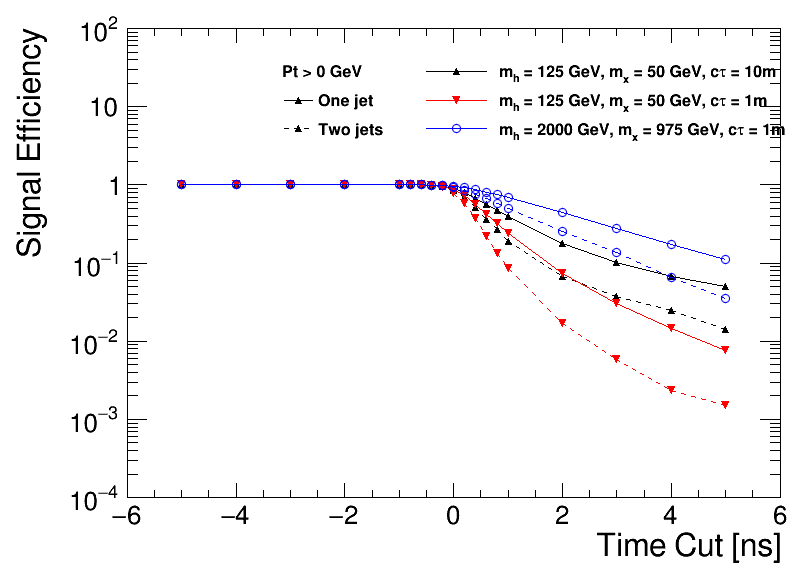

In [27]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==0:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==0:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line.pdf')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0 0
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 6
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 0 12


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt0.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt0.pdf has been created


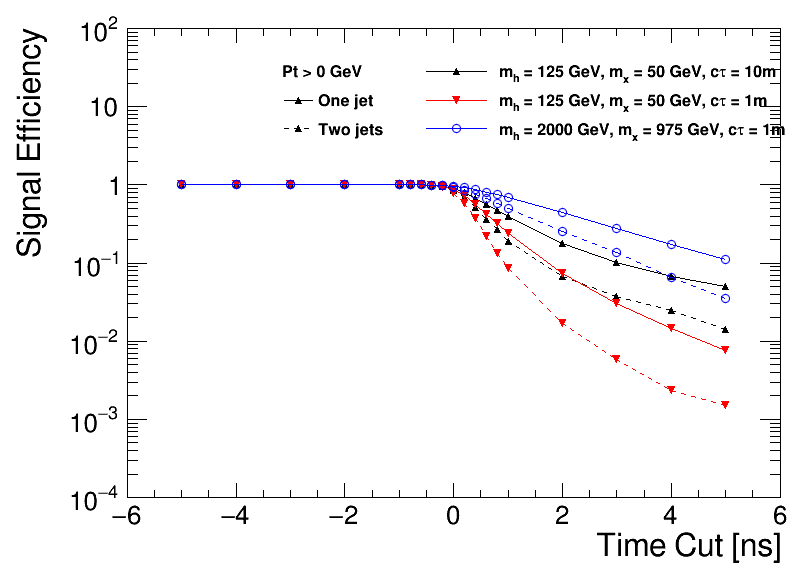

In [28]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==0:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==0:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt0.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt0.pdf')


[-5.  -4.  -3.  -2.  -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   2.   3.   4.   5. ]
bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
pt cut 0
power1 [1.         1.         1.         1.         1.         1.
 0.99921645 0.99294809 0.96924584 0.90107738 0.79804114 0.67032321
 0.56023506 0.4705191  0.39588639 0.17571009 0.10205681 0.06777669
 0.05093046]
power2 [1.         1.         1.         1.         1.         1.
 1.         0.99115044 0.9516678  0.85840708 0.69230769 0.5105514
 0.36487406 0.26820967 0.18992512 0.06807352 0.03744044 0.02450647
 0.01429544]
pt cut 20
power1 [0.58570029 0.58570029 0.58570029 0.58570029 0.58570029 0.58570029
 0.58491675 0.58119491 0.565524   0.52301665 0.46013712 0.37943193
 0.3122429  0.26072478 0.21802155 0.09598433 0.0546523  0.0360431
 0.02644466]
power2 [0.6480599  0.6480599  0.6480599  0.6480599  0.6480599  0.6480599
 0.6480599  0.64193329 0.61742682 0.55071477 0.44111641 0.32334922
 0.23076923 0.16746086 0.12049013 0.0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt20.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt20.pdf has been created


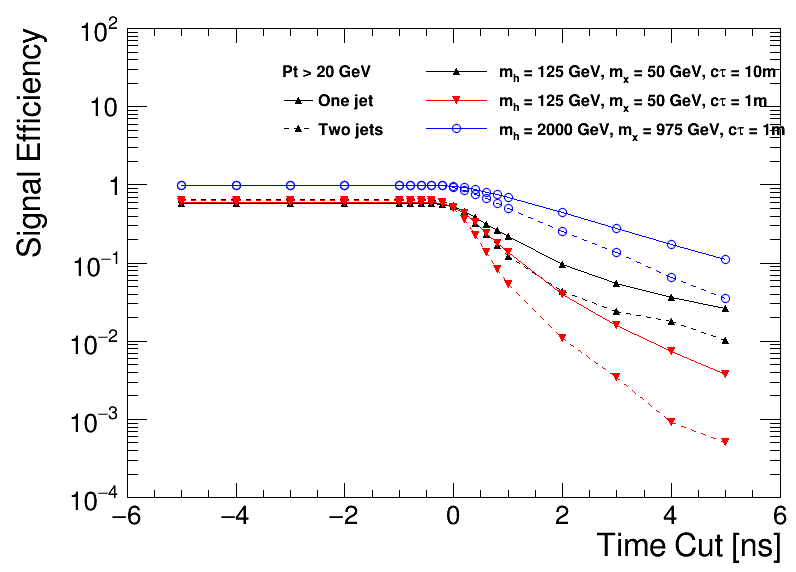

In [29]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
print(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)
        print('pt cut',pt)
        print('power1',power1)
        print('power2',power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==1 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==1:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==1:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt20.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt20.pdf')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 2 2
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 2 8
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 2 14


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt30.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt30.pdf has been created


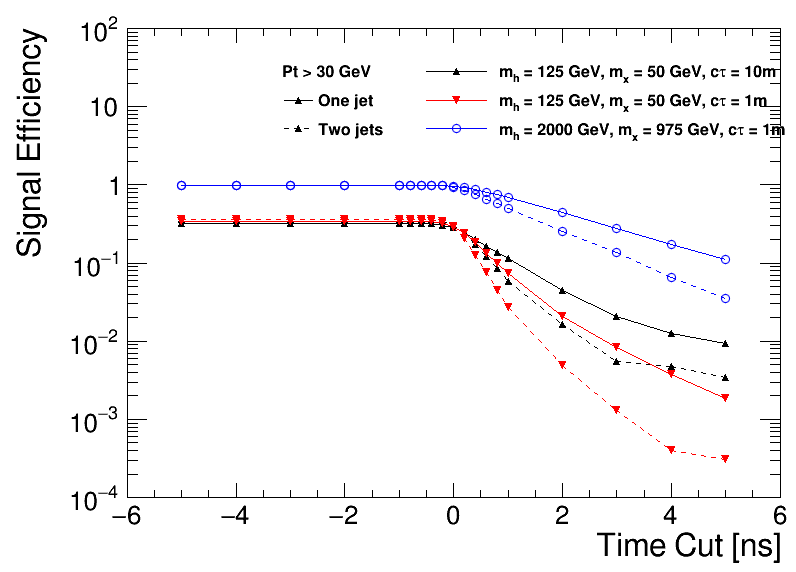

In [30]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==2 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==2:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt30.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt30.pdf')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 3 3
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 3 9
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 3 15


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt40.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt40.pdf has been created


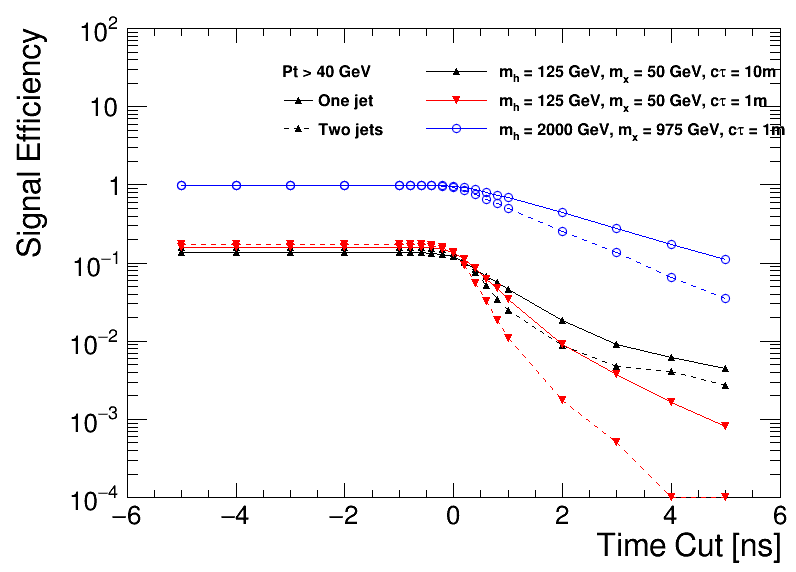

In [31]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==3 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==3:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==3:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt40.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt40.pdf')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 4 4
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 4 10
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 4 16


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt50.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt50.pdf has been created


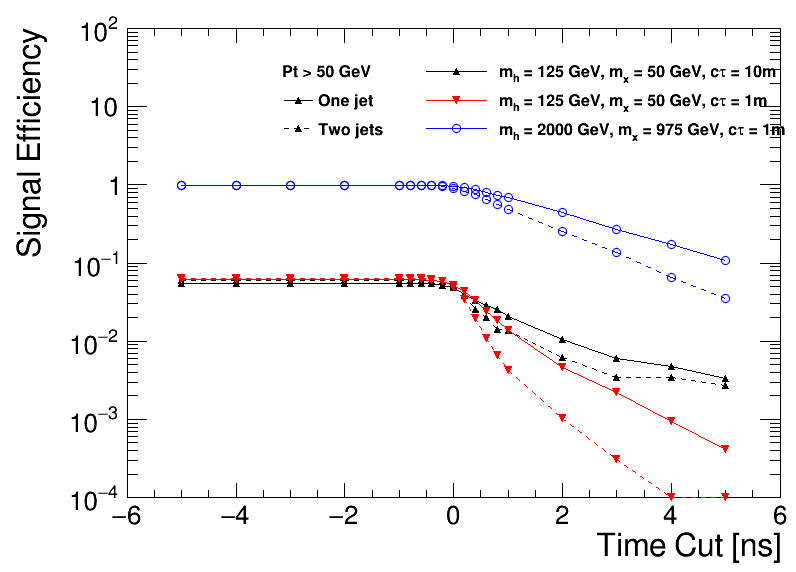

In [32]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==4 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==4:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==4:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt50.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt50.pdf')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 5 5
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 5 11
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 5 17


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt60.png has been created
Info in <TCanvas::Print>: pdf file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt60.pdf has been created


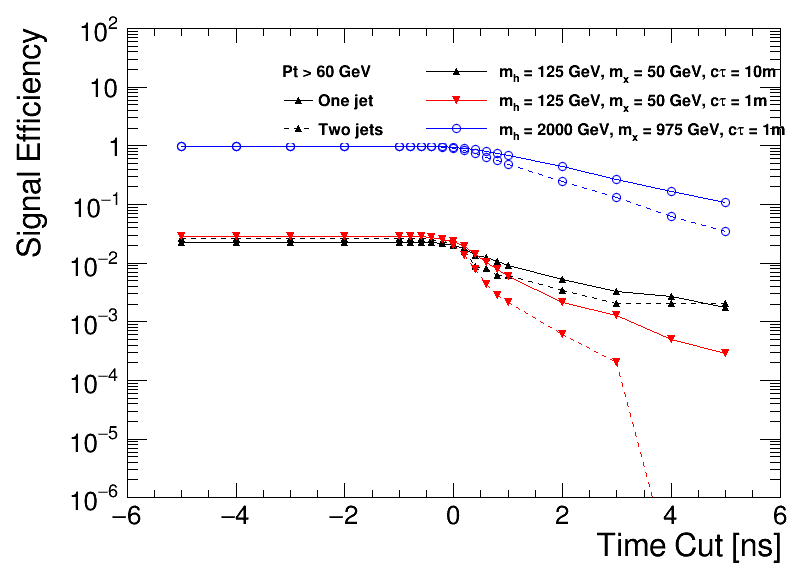

In [35]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[n])
        h1s[i].SetMarkerColor(std_color_list[n])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-6,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==5 and n==0:
            print(n,j,i)
            leg.SetHeader('Pt > '+str(pt)+' GeV')
            h1s[i].Draw('ALPsame')
            leg.AddEntry(h1s[i],'One jet')
            h2s[i].Draw('LPsame')
            leg.AddEntry(h2s[i],'Two jets')
        elif j==5:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            h2s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if j==5:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
    
    n += 1


leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt60.png')
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_2line_pt60.pdf')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 0 12
0.8
0 0.749
2 1 13
20 0.7474285714285714
2 2 14
30 0.7452857142857143
2 3 15
40 0.7432857142857143
2 4 16
50 0.7398571428571429
2 5 17
60 0.7351428571428571


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Mass1.png has been created


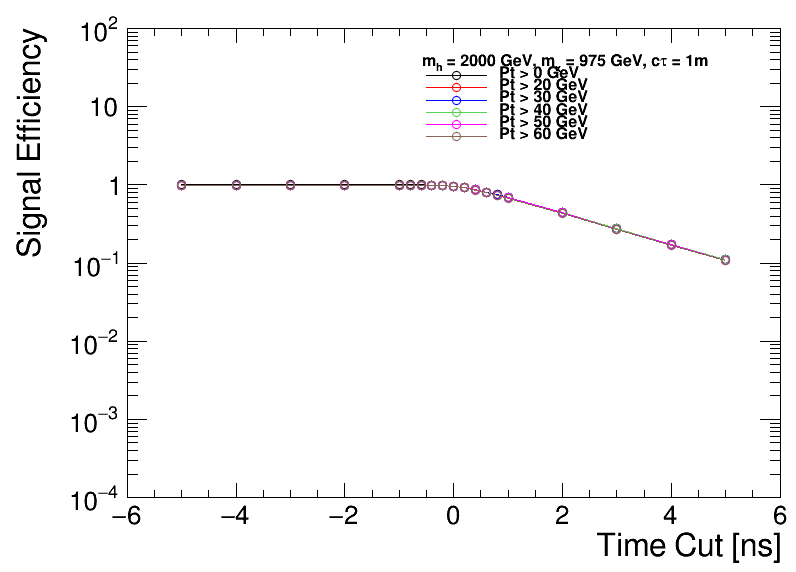

In [36]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==2:
            print(n,j,i)
            h1s[i].Draw('ALPsame')
            print(t_cuts[13])
            print(pt,power1[13])
        elif n==2:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            print(pt,power1[13])
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if n==2:
            leg1.SetHeader(texs[k])
            leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Mass1.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0 0
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Mass2.png has been created


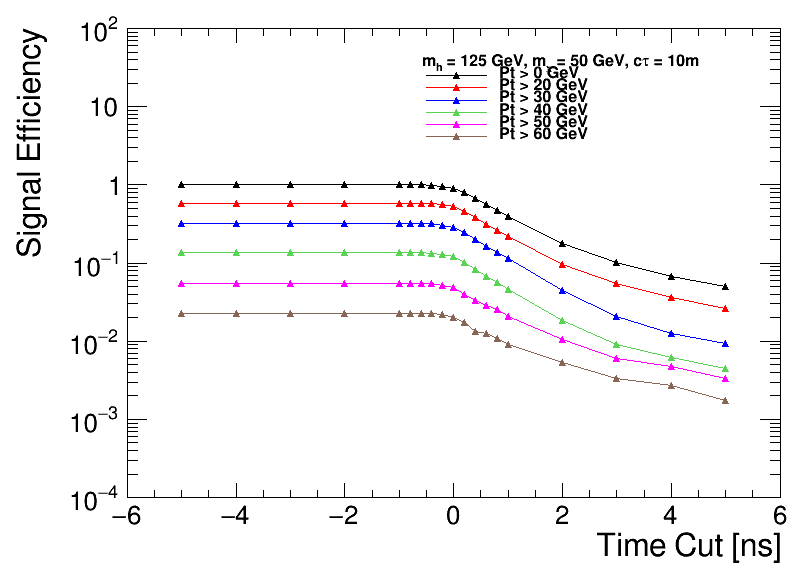

In [37]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==0:
            print(n,j,i)
            h1s[i].Draw('ALPsame')
        elif n==0:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if n==0:
            leg1.SetHeader(texs[k])
            leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Mass2.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 6
1 1 7
1 2 8
1 3 9
1 4 10
1 5 11
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Mass3.png has been created


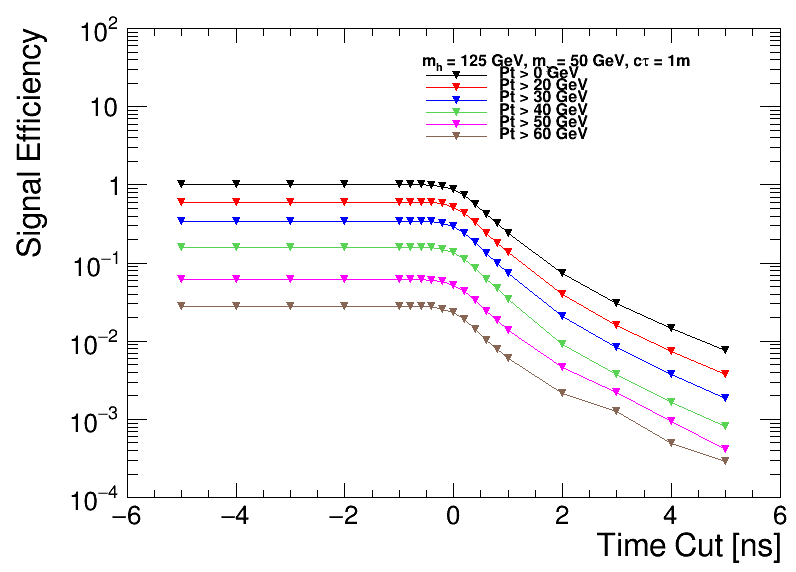

In [38]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==1:
            print(n,j,i)
            h1s[i].Draw('ALPsame')
        elif n==1:
            print(n,j,i)
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
        if n==1:
            leg1.SetHeader(texs[k])
            leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Mass3.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 1 1
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 1 7
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 1 13


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt20.png has been created


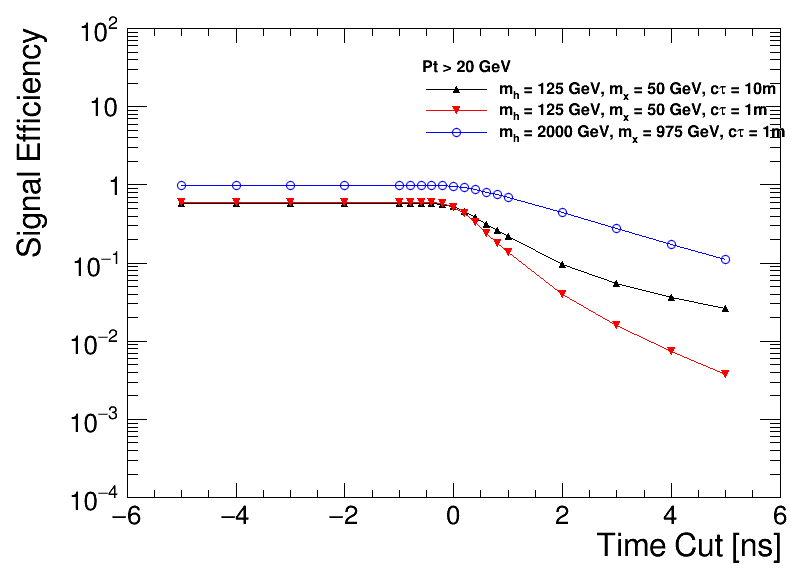

In [39]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==1 and n==0:
            print(n,j,i)
            leg1.SetHeader('Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].SetLineColor(std_color_list[n])
            h1s[i].SetMarkerColor(std_color_list[n])
            h1s[i].Draw('ALPsame')
        elif j==1:
            print(n,j,i)
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].SetLineColor(std_color_list[n])
            h1s[i].SetMarkerColor(std_color_list[n])
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
#         if n==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt20.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 0 0
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 0 6
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 0 12


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt0.png has been created


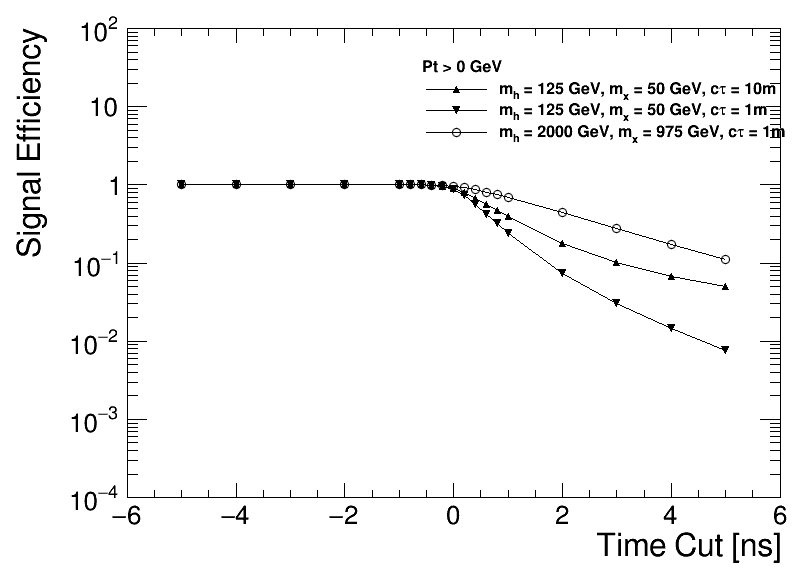

In [40]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==0 and n==0:
            print(n,j,i)
            leg1.SetHeader('Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('ALPsame')
        elif j==0:
            print(n,j,i)
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
#         if n==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt0.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 2 2
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 2 8
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 2 14


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt30.png has been created


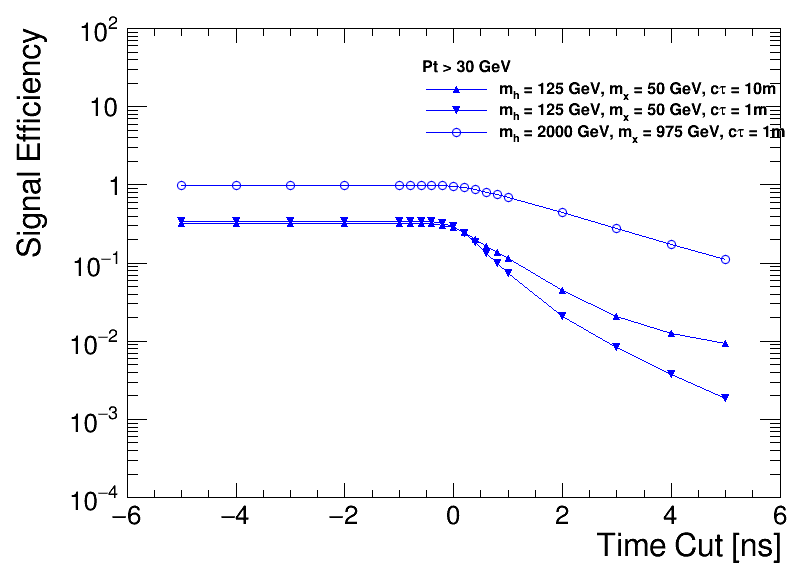

In [41]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==2 and n==0:
            print(n,j,i)
            leg1.SetHeader('Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('ALPsame')
        elif j==2:
            print(n,j,i)
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
#         if n==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt30.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 3 3
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 3 9
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 3 15


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt40.png has been created


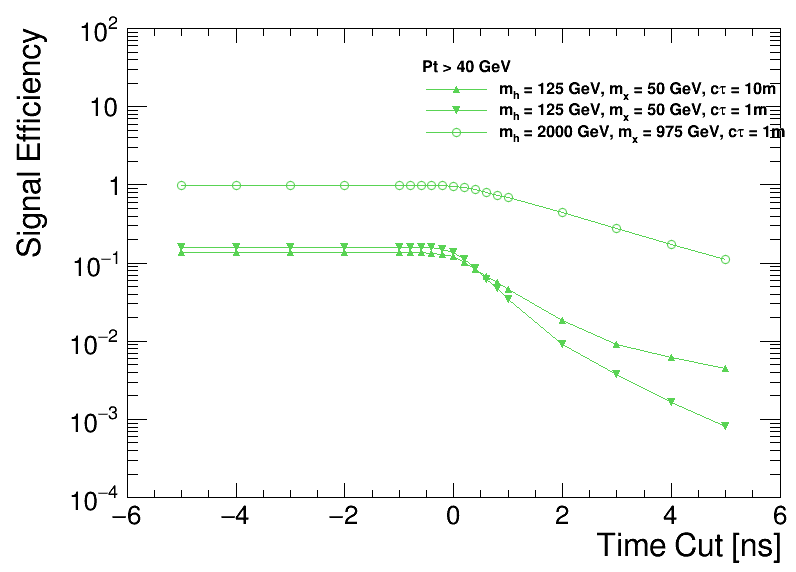

In [42]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==3 and n==0:
            print(n,j,i)
            leg1.SetHeader('Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('ALPsame')
        elif j==3:
            print(n,j,i)
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
#         if n==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt40.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 4 4
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 4 10
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 4 16


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt50.png has been created


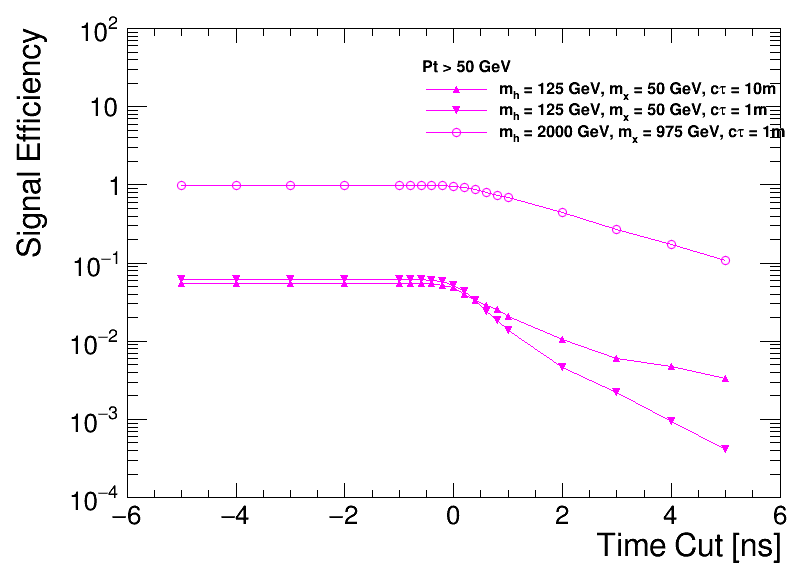

In [43]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==4 and n==0:
            print(n,j,i)
            leg1.SetHeader('Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('ALPsame')
        elif j==4:
            print(n,j,i)
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
#         if n==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt50.png')


bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
0 5 5
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
1 5 11
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
2 5 17


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt60.png has been created


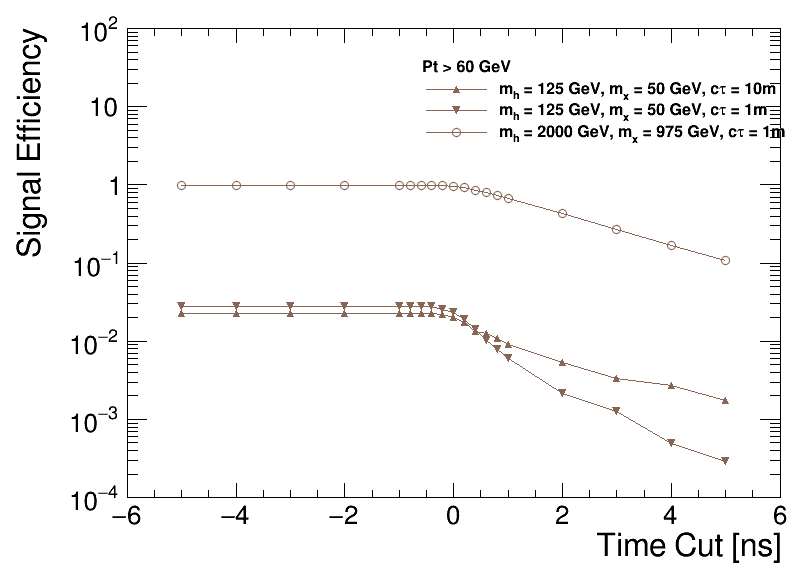

In [44]:
# plot leading n subleading jet time
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
num = len(t_cuts)
t_cuts = np.array(t_cuts)
sigma = [0.2,0.4,0.6,0.8,1.]

c = rt.TCanvas('c','c', 800, 600)
#h = {}
leg = rt.TLegend(0.35,0.75,0.55,0.90);
leg1 = rt.TLegend(0.52,0.75,0.95,0.90);
leg.SetTextSize(0.03)
leg1.SetTextSize(0.03)

rt.gStyle.SetOptStat(0000)
n = 0

h1s = {}
h2s = {}

for k,v in tree.items():   
    print(k, v)
    
    for j,pt in enumerate(pt_cuts):
#         print(j,sig)

        i = n*len(pt_cuts)+j
#         print(n,j,i)

        Power_eff_i = Power_1j_Trgs[i] 

        power1 = np.array(Power_eff_i) 
#         print(num, len(t_cuts), len(power1))
#         print(num, len(t_cuts), len(power1),t_cuts, power1)
        h1s[i] = rt.TGraph(num , t_cuts, power1)

        Power_eff_2j_i = Power_2j_Trgs[i] 

        power2 = np.array(Power_eff_2j_i) 
        h2s[i] = rt.TGraph(num , t_cuts, power2)

        h1s[i].SetLineColor(std_color_list[j])
        h1s[i].SetMarkerColor(std_color_list[j])
        h1s[i].SetMarkerStyle(22+n)
        h1s[i].GetYaxis().SetRangeUser(1e-5,1e2)
        #     hrej[m].SetMarkerSize(2)

        h2s[i].SetLineStyle(7)
        h2s[i].SetLineColor(std_color_list[n])
        h2s[i].SetMarkerColor(std_color_list[n])
        h2s[i].SetMarkerStyle(22+n)
        h2s[i].GetYaxis().SetRangeUser(1e-5,1e2)


        leg.SetBorderSize(0)
        leg1.SetBorderSize(0)
#         leg.AddEntry(h2s[i],k+' Two jets')

        h1s[i].SetTitle( 'Signal Efficiency' )
        h1s[i].GetXaxis().SetTitle( 'Time Cut [ns]' )
        #hrej[m].GetXaxis().SetRangeUser(-10,10)
        h1s[i].GetYaxis().SetRangeUser(1e-4,1e2)
        h1s[i].GetYaxis().SetTitle( 'Signal Efficiency' )
        if j==5 and n==0:
            print(n,j,i)
            leg1.SetHeader('Pt > '+str(pt)+' GeV')
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('ALPsame')
        elif j==5:
            print(n,j,i)
            leg1.AddEntry(h1s[i],texs[k])
            h1s[i].Draw('LPsame')
            
#         if n==2 :
#             leg1.AddEntry(h2s[i],' Two jets')
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#         else:
#             leg.AddEntry(h1s[i],'#sigma_{BS} = '+str(sig)+'ns')
#             h2s[i].Draw('LPsame')
#         if n==2:
#             leg1.SetHeader(texs[k])
#             leg1.AddEntry(h1s[i],'Pt > '+str(pt)+' GeV')
    
    n += 1


# leg.Draw()
leg1.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'SignalEff_GenTime_Max_Second_Time_Smear_1jet_Trgs_Masses_pt60.png')


In [38]:
import scipy.stats

In [39]:
scipy.stats.norm(0, 1)

In [40]:
scipy.stats.norm.sf(1,0,0.2)

2.866515718791933e-07

In [41]:
1/2.866515718791933e-07

3488555.787237898

# Gen level of LLP vertices

bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f4adff3de80>
bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f4adf367c50>
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f4adf1f5da0>
 FCN=25.8614 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=4.14704e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.81677e+03   2.11259e+01   4.29142e-02  -4.19917e-06
   2  Mean        -1.10908e+00   2.42756e-02   6.13433e-05  -5.97490e-03
   3  Sigma        5.32566e+00   1.84595e-02   2.37570e-06   1.52167e-01
 FCN=13.9771 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=4.7429e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIV

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190716/LLP_Prod_Vtx_z.png has been created


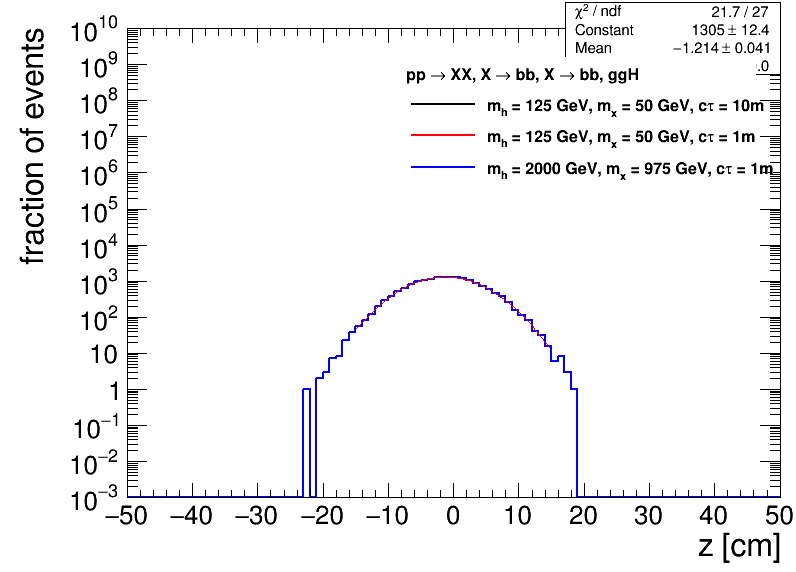

In [45]:
# plot leading jet time
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.50,0.68,0.95,0.90);
leg.SetTextSize(0.03)
rt.gStyle.SetOptStat(0000)
i = 0

htm ={}
for k,v in tree.items():   
    print(k, v)
    LLP_prod_z = v['gLLP_prod_vertex_z'].array()
    z = LLP_prod_z[:,0]
#     jetGenTime = v['gen_time'].array()
#     jetmatch = v['gLLP_daughter_match_jet_index'].array()
#     weight = v['genWeight'].array()
#     t = jetGenTime[:,0]
#     vt = jetGenTime[jetmatch!=666]
#     print(jetGenTime[0],jetmatch[0],vt[0:10])
#     t = vt[:0]
#     ht0[k] = create_TH1D( t, axis_title=['GenTime [ns]', 'fraction of events'], name=k, binning=[100,-5,50])
    htm[k] = create_TH1D( z, axis_title=[' z [cm]', 'fraction of events'], name=k, binning=[100,-50,50])
#     ht0[k] = create_TH1D( t, axis_title=['GenTime [ns]', 'fraction of events'], name=k, binning=[100,-5,50], weights = weight)
    htm[k].SetLineColor(std_color_list[i])
    htm[k].SetMarkerColor(std_color_list[i])
    htm[k].GetYaxis().SetRangeUser(1e-3,1e10)


    leg.AddEntry(htm[k],texs[k])

    htm[k].DrawNormalized('same')
    htm[k].Fit('gaus','','',-15,15)
    
    i += 1

leg.SetHeader(str(MODEL))
leg.SetBorderSize(0)

leg.Draw()
c.SetLogy()
c.Update()
c.Draw()
c.SaveAs(out_dir+'LLP_Prod_Vtx_z.png')
